<h1 style="font-family: Cambria; text-align: center;">
Data Preprocessing
</h1>

In [1]:
import os
import json
import h5py
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

<div style="font-family: Cambria;">
Please update the "BASE_PATH" variable to your specific directory!
</div>

In [2]:
# Update the base path to the specific directory.
BASE_PATH = "/data1/wangteng/raw/channelflow-dns-re544-seq-p000-020"

In [3]:
GRID_PATH = os.path.join(BASE_PATH, "grid")
DATA_PATH = os.path.join(BASE_PATH, "data")
INFO_PATH = os.path.join(BASE_PATH, "info.json")

<div style="font-family: Cambria;">
Load global information.
</div>

In [4]:
try:
    with open(INFO_PATH, 'r') as f:
        info = json.load(f)
except FileNotFoundError:
    print(f"[ERROR] info.json not found at {INFO_PATH}")
    raise

<h2 style="font-family: Cambria; text-align: center;">
Task 1: Grid Analysis
</h2>

In [5]:
# Data shape.
NX, NY, NZ = info["global"]["Nxyz"]
print(f"Data Shape: ({NX}, {NY}, {NZ})")

Data Shape: (1536, 384, 1024)


<div style="font-family: Cambria;">
Function for checking uniformity of the 1D grid and plotting its distribution.
</div>

In [6]:
def analyze_grid(filepath, expected_count, dimension_name, dtype=np.float32):
    """
    Load a 1D grid file, check its uniformity, and plot the distribution.
    
    Args:
        filepath (str):         Path to the .dat grid file.
        expected_count (int):   The expected number of points (e.g., NX, NY, NZ).
        dimension_name (str):   The name of the dimension ('X', 'Y', or 'Z').
        dtype (np.dtype):       The numpy data type to read the file.
    """
    print(f"Analyzing Grid for Dimension: {dimension_name}")
    
    # Check if file exists
    if not os.path.exists(filepath):
        print(f"[ERROR] File not found: {filepath}")
        return

    try:
        # Load the binary data from file
        grid_data = np.fromfile(filepath, dtype=dtype)
        
        # 1. Check if the loaded data count matches the expected count
        if grid_data.shape[0] != expected_count:
            print(f"[Mismatch] For dimension {dimension_name}, expected {expected_count} but found {grid_data.shape[0]}.")
            return
        else:
            print(f"[Match] Shape of dimension {dimension_name} matched!")
            print(grid_data.shape[0])

        # 2. Check for uniformity
        diffs = np.round(np.diff(grid_data), decimals=5)
        is_uniform = np.allclose(diffs, diffs[0])

        if is_uniform:
            print(f"[Uniform] Grid in dimension {dimension_name} is uniform.")
        else:
            print(f"[Non-uniform] Grid in dimension {dimension_name} is non-uniform.")

        # 3. Plot the grid point distribution.
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        fig.suptitle(f"Grid Analysis for Dimension: {dimension_name}", fontsize=16)

        # Plot grid point values vs. index
        ax1.plot(grid_data, '.-', markersize=4)
        ax1.set_title(f"Grid Point Value (N={expected_count})")
        ax1.set_xlabel("Grid Index")
        ax1.set_ylabel(f"{dimension_name} Coordinate")

        # Plot the spacing.
        diff_indices = np.arange(len(diffs))
        ax2.scatter(diff_indices, diffs, s=4) 

        ax2.set_title("Spacing between Grid Points")
        ax2.set_xlabel("Grid Index")
        ax2.set_ylabel("Spacing")

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
        
    except Exception as e:
        print(f"[ERROR] An error occurred: {e}")


Analyzing Grid for Dimension: X
[Match] Shape of dimension X matched!
1536
[Uniform] Grid in dimension X is uniform.


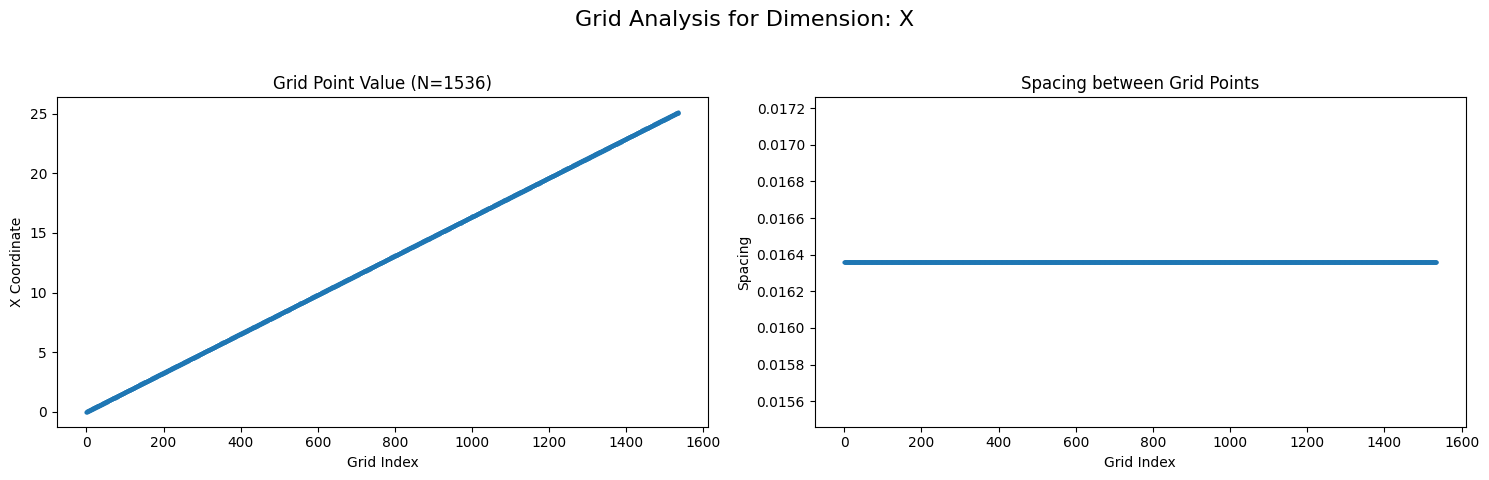

Analyzing Grid for Dimension: Y
[Match] Shape of dimension Y matched!
384
[Non-uniform] Grid in dimension Y is non-uniform.


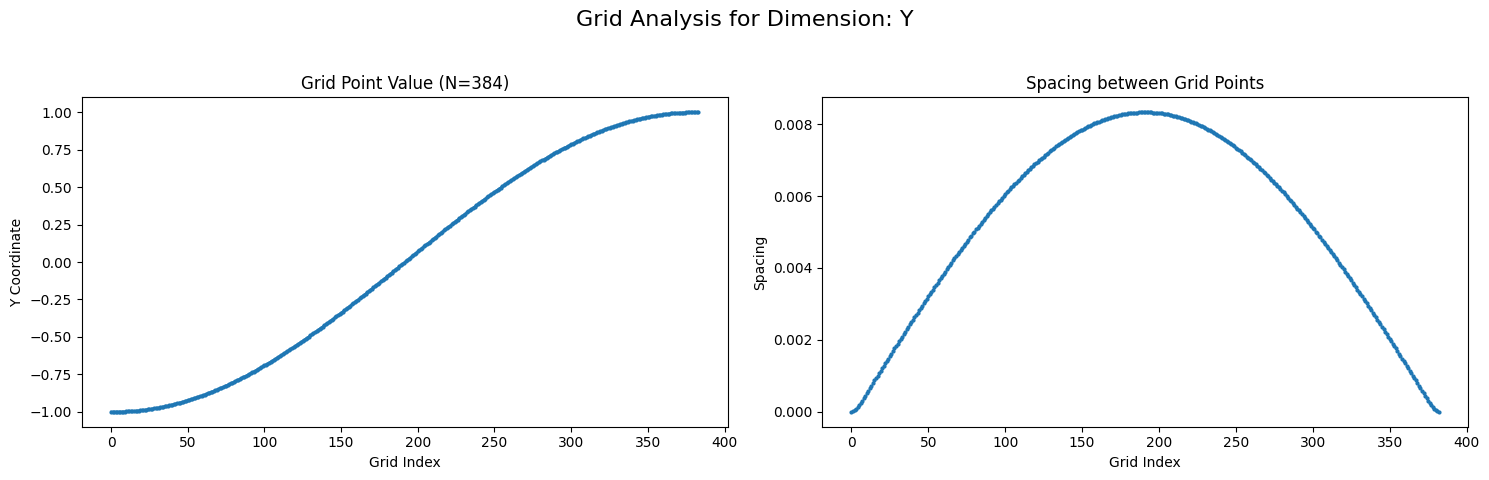

Analyzing Grid for Dimension: Z
[Match] Shape of dimension Z matched!
1024
[Uniform] Grid in dimension Z is uniform.


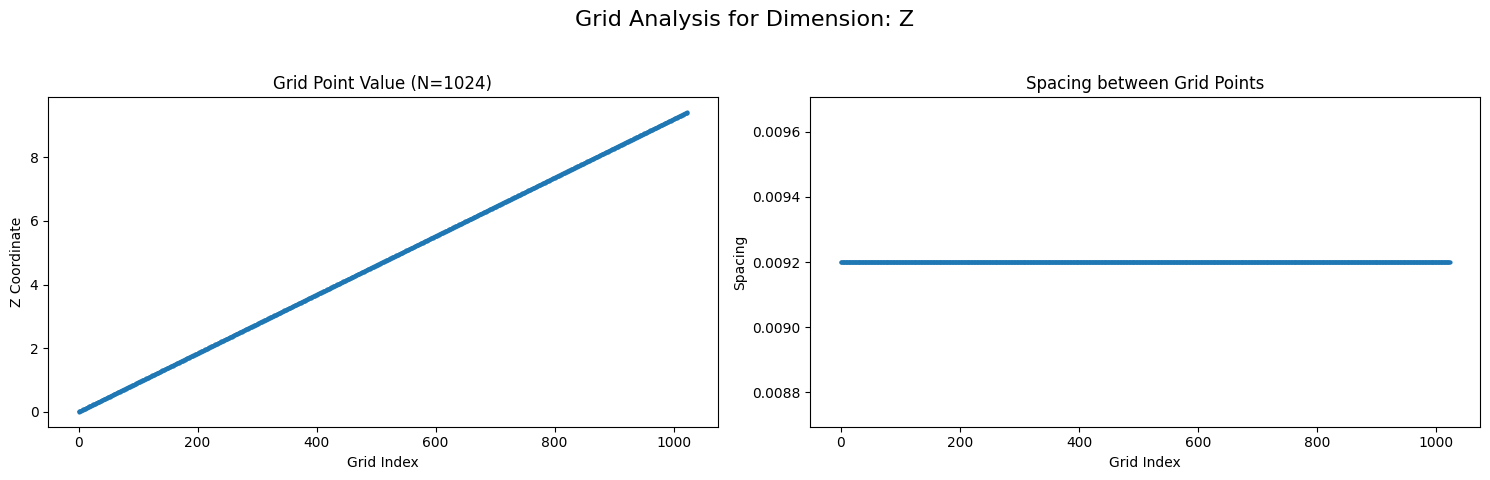

In [7]:
if not os.path.exists(GRID_PATH):
    print(f"Error: The path '{GRID_PATH}' does not exist. Please update the 'GRID_PATH' variable.")
else:
    analyze_grid(GRID_PATH + "/X_m.dat", NX, 'X', dtype=np.float32)
    analyze_grid(GRID_PATH + "/Y_m.dat", NY, 'Y', dtype=np.float32)
    analyze_grid(GRID_PATH + "/Z_m.dat", NZ, 'Z', dtype=np.float32)

<div style="font-family: Cambria;">
Conclusion: The dataset channel-flow is of structured grids, but inhomogeneous in the verbal direction (Y-coords).
</div>

<h2 style="font-family: Cambria; text-align: center;">
Task 2: Calculation of Global Statistics.
</h2>

<div style="font-family: Cambria;">
Replace with your specific direcotry to save the statistics.
</div>

In [8]:
CSV_OUTPUT_PATH = "./channel_flow_stats.csv"

is_exists = os.path.exists(CSV_OUTPUT_PATH)
if is_exists:
    print(f"[INFO] Statistics file found: '{CSV_OUTPUT_PATH}'")
    print("Loading existing data...")
    stats_df = pd.read_csv(CSV_OUTPUT_PATH, index_col=0)
    print(stats_df)
else:
    print(f"[INFO] Statistics file not found. Starting calculation...")

[INFO] Statistics file found: './channel_flow_stats.csv'
Loading existing data...
                 mean       std       min       max        count
P_Pa    -1.837980e-03  0.005634 -0.164516  0.121807  12683575296
UX_ms-1  8.475280e-01  0.332693 -0.117360  1.372426  12683575296
UY_ms-1 -2.070538e-14  0.042872 -0.411603  0.415426  12683575296
UZ_ms-1 -4.357415e-04  0.054912 -0.481439  0.458521  12683575296


In [9]:
N_POINTS_PER_SNAPSHOT = NX * NY * NZ
print(f"Total points per snapshot: {N_POINTS_PER_SNAPSHOT}")

Total points per snapshot: 603979776


<div style="font-family: Cambria;">
Load the metadata.
</div>

In [10]:
print(f"Loading metadata from: {INFO_PATH}")

# Get variables and snapshots.
variables = info['global']['variables']
snapshots = info['local']
print(f"Found {len(variables)} variables and {len(snapshots)} snapshots.")

Loading metadata from: /data1/wangteng/raw/channelflow-dns-re544-seq-p000-020/info.json
Found 4 variables and 21 snapshots.


In [11]:
# Populate file paths.
file_paths = {var: [] for var in variables}
for snap in snapshots:
    snap_id_str = f"id{snap['id']:04d}.dat"

    file_paths['P_Pa'].append(os.path.join(DATA_PATH, f"P_Pa_{snap_id_str}"))
    file_paths['UX_ms-1'].append(os.path.join(DATA_PATH, f"UX_ms-1_{snap_id_str}"))
    file_paths['UY_ms-1'].append(os.path.join(DATA_PATH, f"UY_ms-1_{snap_id_str}"))
    file_paths['UZ_ms-1'].append(os.path.join(DATA_PATH, f"UZ_ms-1_{snap_id_str}"))

<div style="font-family: Cambria;">
Loop through all files to calculate statstics.
</div>

In [12]:
if not is_exists:
    stats = {
        var: {
            'sum': 0.0,
            'sum_square': 0.0,
            'count': 0,
            'min': np.finfo(np.float64).max,
            'max': np.finfo(np.float64).min
        } for var in variables
    }

    print("\nStarting statistics calculation (this may take a while)...")
    for var in tqdm(variables, desc="Processing Variables"):
        for f_path in tqdm(file_paths[var], desc=f" {var} ", leave=False):
            if not os.path.exists(f_path):
                print(f"[Warning] File not found, skipping: {f_path}")
                continue
            
            data = np.fromfile(f_path, dtype=np.float32)
            if data.shape[0] != N_POINTS_PER_SNAPSHOT:
                print(f"[Warning] Size mismatch in {f_path}, skipping.")
                continue  
            # Use float64 for sums to avoid overflow!
            data_f64 = data.astype(np.float64)

            # Update running statistics.
            stats[var]['sum'] += np.sum(data_f64)
            stats[var]['sum_square'] += np.sum(data_f64 ** 2)
            stats[var]['count'] += data.size

            file_min = np.min(data_f64)
            if file_min < stats[var]['min']:
                stats[var]['min'] = file_min
                
            file_max = np.max(data_f64)
            if file_max > stats[var]['max']:
                stats[var]['max'] = file_max

    print("Statistics calculation complete.")

<div style="font-family: Cambria;">
Calculate the final statisitcs and save to .csv file.
</div>

In [13]:
if not is_exists:    
    print("\nCalculating final Mean and Std...")
    final_stats = {}

    for var, data in stats.items():
        if data['count'] == 0:
            print(f"[Warning] No data found for {var}.")
            continue
        
        # Calculate mean and variance.
        mean = data["sum"] / data["count"]
        variance = (data["sum_square"] / data["count"]) - (mean ** 2)     
         
        # Prevent NaN from small negative variance.
        if variance < 0:
            print(f"[Notice] Clamping small negative variance for {var} to 0.0")
            variance = 0.0
        std_dev = np.sqrt(variance)
        
        final_stats[var] = {
            'mean': mean,
            'std': std_dev,
            'min': data['min'],
            'max': data['max'],
            'count': data['count']
        }

In [14]:
if not is_exists:
    stats_df = pd.DataFrame.from_dict(final_stats, orient='index')
    print("Statistics Summary: ")
    print(stats_df)

    stats_df.to_csv(CSV_OUTPUT_PATH)
    print(f"\n[SUCCESS] Flow statistics saved to: {CSV_OUTPUT_PATH}")

<div style="font-family: Cambria;">
Functions for plotting 2D slices.
</div>

In [15]:
def get_slice_data(full_3d_data, slice_axis, slice_index, nx, ny, nz):
    """
    A helper function: slices the 3D data and generates plot metadata using a data-driven approach.
    """
    slice_axis = slice_axis.upper()
    metadata_lookup = {
        'X': ('Y', 'Z', ny, nz, 'Y-Z'),
        'Y': ('X', 'Z', nx, nz, 'X-Z'),
        'Z': ('X', 'Y', nx, ny, 'X-Y')
    }

    if slice_axis not in metadata_lookup:
        print(f"[ERROR] Invalid slice_axis: '{slice_axis}'. Must be 'X', 'Y', or 'Z'.")
        return None, None, None, None

    if slice_axis == 'X':
        data_slice = full_3d_data[slice_index, :, :]
    elif slice_axis == 'Y':
        data_slice = full_3d_data[:, slice_index, :]
    elif slice_axis == 'Z':
        data_slice = full_3d_data[:, :, slice_index]
    plot_data = data_slice.T

    ax1_name, ax2_name, dim1, dim2, plane = metadata_lookup[slice_axis]
    xlabel = f"{ax1_name} Grid Index (0 to {dim1 - 1})"
    ylabel = f"{ax2_name} Grid Index (0 to {dim2 - 1})"
    title = f"{plane} Plane at {slice_axis} = {slice_index}"
    
    return plot_data, xlabel, ylabel, title

def plot_2d_slice(variable, snapshot_id, slice_axis, slice_index, ax, data_path, nx, ny, nz, dtype=np.float32, cmap='RdBu_r'):
    """
    Loads one 3D snapshot file and plots a 2D slice on a given Axes object.
    """
    
    file_name = f"{variable}_id{snapshot_id:04d}.dat"
    file_path = os.path.join(data_path, file_name)
    if not os.path.exists(file_path):
        print(f"[ERROR] File not found: {file_path}")
        return None

    try:
        full_3d_data = np.fromfile(file_path, dtype=dtype).reshape((nx, ny, nz))
        plot_data, xlabel, ylabel, title = get_slice_data(full_3d_data, slice_axis, slice_index, nx, ny, nz)

        # Plot on the provided ax object.
        img = ax.imshow(plot_data, aspect='auto', origin='lower', cmap=cmap)
        ax.set_title(f"{variable}\n{title}", fontsize=12)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        
        return img 

    except Exception as e:
        print(f"[ERROR] An error occurred during loading or plotting: {e}")
        return None


Plotting 4 variables on a X-slice at index 51 for snapshot 20...


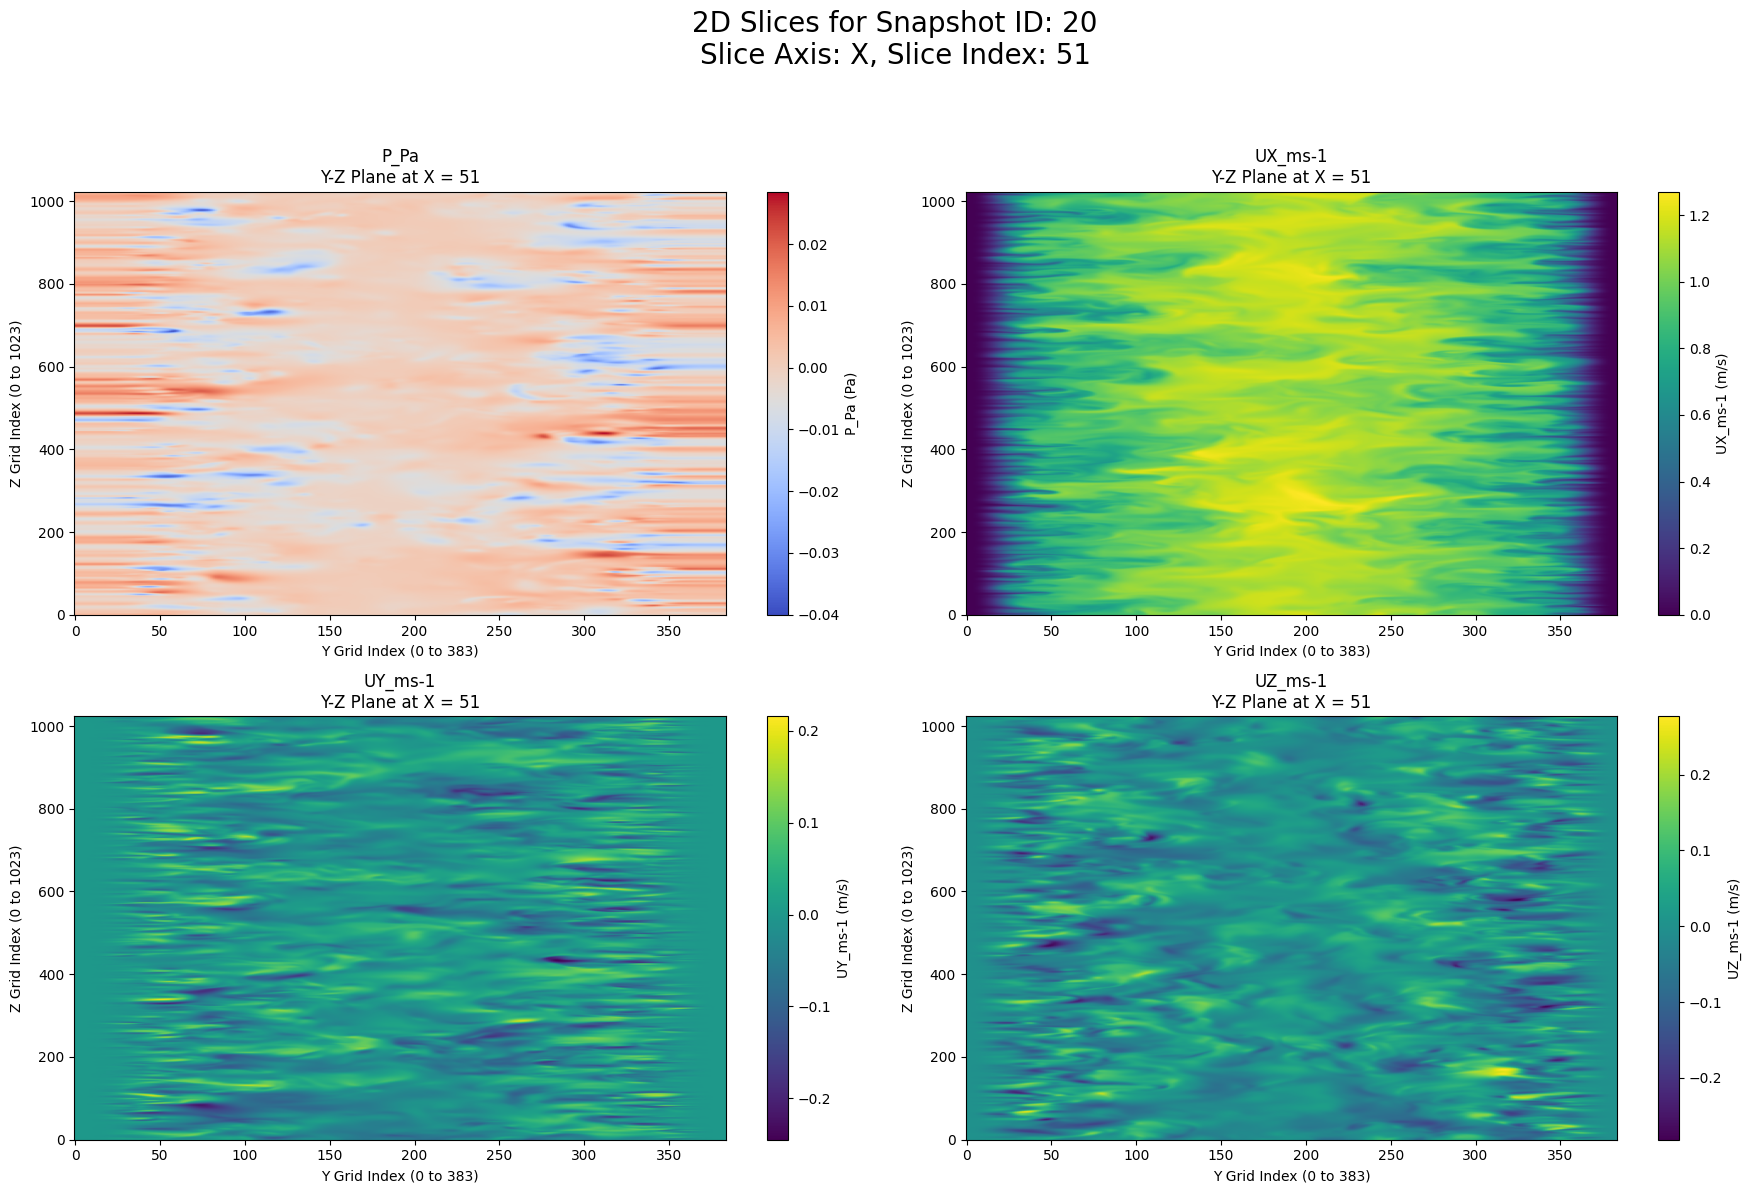

In [16]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Randomly select a snapshot ID.
NUM_SNAPSHOTS = 21
selected_snapshot_id = random.randint(0, NUM_SNAPSHOTS - 1)

# Randomly select a slice index and axis.
axis_options = {
    'X': NX - 1,
    'Y': NY - 1,
    'Z': NZ - 1
}
SLICE_AXIS = random.choice(list(axis_options.keys()))
SLICE_INDEX = random.randint(0, axis_options[SLICE_AXIS])

# Plot 4 variables of the slice.
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()
print(f"\nPlotting 4 variables on a {SLICE_AXIS}-slice at index {SLICE_INDEX} for snapshot {selected_snapshot_id}...")

all_imgs = []
for i, variable in enumerate(["P_Pa", "UX_ms-1", "UY_ms-1", "UZ_ms-1"]):
    current_ax = axes[i]
    img = plot_2d_slice(variable=variable, snapshot_id=selected_snapshot_id, slice_axis=SLICE_AXIS, 
                        slice_index=SLICE_INDEX, ax=current_ax, data_path=DATA_PATH, nx=NX, ny=NY, nz=NZ,
                        cmap='coolwarm' if variable == "P_Pa" else 'viridis'
                        )
    
    if img is not None:
        all_imgs.append(img)
        cbar_label = f"{variable} ({'Pa' if 'P_' in variable else 'm/s'})"
        plt.colorbar(img, ax=current_ax, orientation='vertical', label=cbar_label, pad=0.05)

# Add a main title for the entire figure.
fig.suptitle(f"2D Slices for Snapshot ID: {selected_snapshot_id}\nSlice Axis: {SLICE_AXIS}, Slice Index: {SLICE_INDEX}", 
             fontsize=20, y=1.02)

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

<div style="font-family: Camria;">
Functions for plotting a 3D scatter of a subsampled 2D slice.
</h>

In [17]:
def plot_3d_scatter_slice(variable, snapshot_id, slice_axis, slice_index,stats_df, data_path, nx, ny, nz,
                          n_subsample=10_000, dtype=np.float32,cmap='viridis', elev=30, azim=-60):
    """
    Plots a STATIC 3D scatter plot of a subsampled 2D slice, with a plane at the global mean. 
    """
    # Load the full 3D snapshot data.
    file_name = f"{variable}_id{snapshot_id:04d}.dat"
    file_path = os.path.join(data_path, file_name)
    print(f"\n3D Scatter for: {variable} (Snapshot {snapshot_id})")

    try:
        full_3d_data = np.fromfile(file_path, dtype=dtype).reshape((nx, ny, nz))
        
        # Extract 2D Slice.
        slice_axis = slice_axis.upper()
        if slice_axis == "X":
            data_slice = full_3d_data[slice_index, :, :]
            dim1_coords = np.arange(ny)
            dim2_coords = np.arange(nz)
            xlabel_text = 'Y Grid Index'
            ylabel_text = 'Z Grid Index'
        elif slice_axis == "Y":
            data_slice = full_3d_data[:, slice_index, :]
            dim1_coords = np.arange(nx)
            dim2_coords = np.arange(nz)
            xlabel_text = 'X Grid Index'
            ylabel_text = 'Z Grid Index'
        elif slice_axis == 'Z':
            data_slice = full_3d_data[:, :, slice_index]
            dim1_coords = np.arange(nx)
            dim2_coords = np.arange(ny)
            xlabel_text = 'X Grid Index'
            ylabel_text = 'Y Grid Index'
        else:
            print(f"[ERROR] Invalid slice_axis: '{slice_axis}'.")
            return

        # Subsample the 2D slice.
        values_flat = data_slice.flatten()
        all_indices = np.arange(values_flat.size)
        
        np.random.seed(SEED)
        sample_indices = np.random.choice(all_indices, n_subsample, replace=False)
        sample_values = values_flat[sample_indices]
        sample_dim1, sample_dim2 = np.unravel_index(sample_indices, data_slice.shape)
        print(f"Subsampled {n_subsample} points for 3D scatter plot.")

        # Plot the 3D Scatter.
        fig = plt.figure(figsize=(15, 10))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(sample_dim1, sample_dim2, sample_values, c=sample_values, cmap=cmap, s=5, alpha=0.6)
        
        # Plot the Global Mean Plane.
        global_mean = stats_df.loc[variable]['mean']
        X_mesh, Y_mesh = np.meshgrid(dim1_coords, dim2_coords)
        Z_plane = np.full_like(X_mesh, global_mean, dtype=np.float64)
        ax.plot_surface(X_mesh, Y_mesh, Z_plane, color='red', alpha=0.2, label='Global Mean')

        # Set-up of the figure.
        ax.set_xlabel(xlabel_text)
        ax.set_ylabel(ylabel_text)
        ax.set_zlabel(f"Value ({variable})")
        
        cbar = fig.colorbar(scatter, ax=ax, shrink=0.7, pad=0.1)
        cbar.set_label(f"Value ({variable})")
        
        ax.set_title(f"3D Scatter of {variable} ({slice_axis}-Slice at index {slice_index} of Snapshot {snapshot_id})\n"
                     f"Global Mean: {global_mean:.4f}", fontsize=16)
        
        ax.view_init(elev=elev, azim=azim) 
        
        g_min = stats_df.loc[variable]['min']
        g_max = stats_df.loc[variable]['max']
        ax.set_zlim(min(g_min, np.min(sample_values)) * 1.05, max(g_max, np.max(sample_values)) * 1.05)

        plt.show()

    except Exception as e:
        print(f"[ERROR] An error occurred: {e}")


3D Scatter for: P_Pa (Snapshot 20)
Subsampled 10000 points for 3D scatter plot.


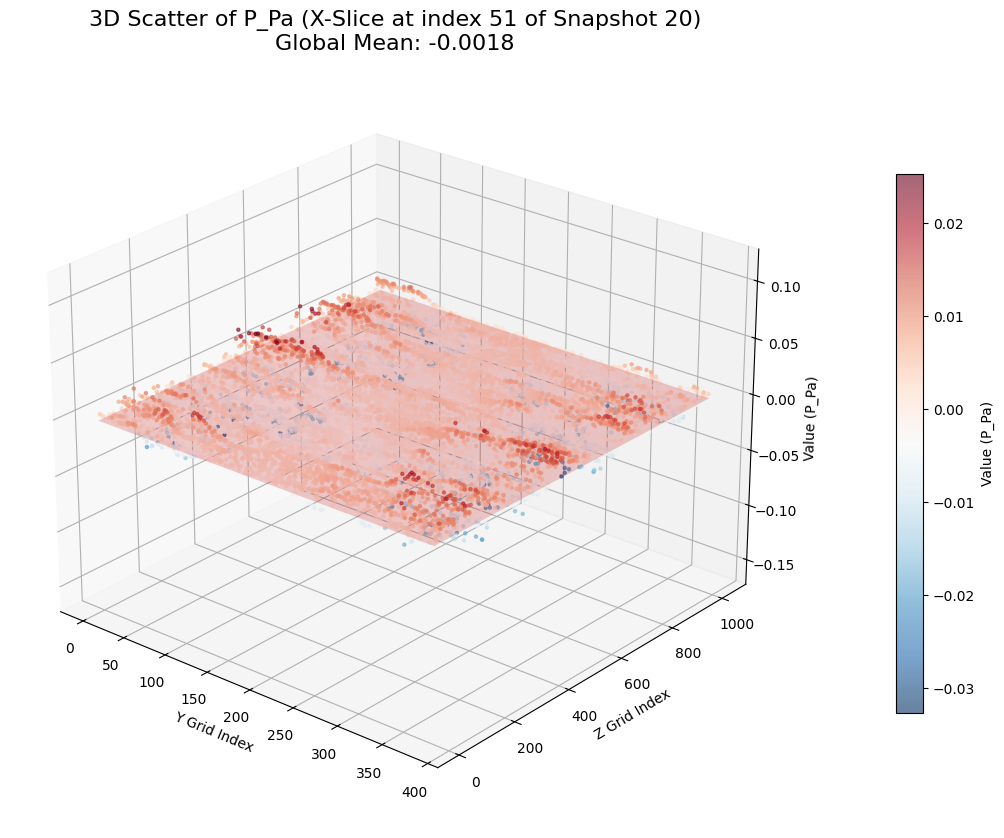

In [18]:
# Ensure that global stats are loaded.
if 'stats_df' not in locals():
     stats_df = pd.read_csv(CSV_OUTPUT_PATH, index_col=0)
     print("Loaded global stats.")

plot_3d_scatter_slice(
    variable="P_Pa",
    snapshot_id=selected_snapshot_id,
    slice_axis=SLICE_AXIS,
    slice_index=SLICE_INDEX,
    stats_df=stats_df,
    data_path=DATA_PATH,
    nx=NX, ny=NY, nz=NZ,
    n_subsample=10_000,
    cmap='RdBu_r',
    elev=25, azim=-50
)

<h2 style="font-family: Cambria; text-align: center;">
Task 3: Normalization
</h2>

<div style="font-family: Cambria;">
Replace with your specific direcotry to store data which have been processed.
</div>

In [19]:
HDF5_OUTPUT_PATH = "/data1/wangteng/processed/channel_flow.hdf5"

is_exists_hdf5 = os.path.exists(HDF5_OUTPUT_PATH)
if is_exists_hdf5:
    print(f"[INFO] Normalized file found: {HDF5_OUTPUT_PATH}. Skipping normalization.")
else:
    print(f"[INFO] Normalized file not found. Starting normalization...")

[INFO] Normalized file not found. Starting normalization...


In [20]:
if not is_exists_hdf5:
    print(f"Creating HDF5 file at: {HDF5_OUTPUT_PATH}")
    
    with h5py.File(HDF5_OUTPUT_PATH, 'w') as f:  
        # Store times and IDs of 0-20 snapshots.
        print("Storing time step and metadata...")
        metadata_group = f.create_group('metadata')

        times = np.array([snap['time'] for snap in snapshots], dtype=np.float32)
        ids = np.array([snap['id'] for snap in snapshots], dtype=np.int32)
        metadata_group.create_dataset('times', data=times)
        metadata_group.create_dataset('snapshot_ids', data=ids)

        # Normalize 4 main variables.
        print("Starting normalization and save loop...")
        for var in tqdm(variables, desc="Total Progress"):
            mean, std = stats_df.loc[var]['mean'], stats_df.loc[var]['std']

            var_group = f.create_group(var)
            for i, raw_path in enumerate(tqdm(file_paths[var], desc=f" {var} ", leave=False)):
                raw_data = np.fromfile(raw_path, dtype=np.float32).reshape((NX, NY, NZ))
                normalized_data = ((raw_data.astype(np.float64) - mean) / std).astype(np.float32)
                
                dataset_name = f"id_{i:04d}"
                var_group.create_dataset(
                    dataset_name, data=normalized_data, compression="gzip", compression_opts=4
                )

    print("[SUCCESS] HDF5 file creation complete.")
    print(f"File saved to: {HDF5_OUTPUT_PATH}")

Creating HDF5 file at: /data1/wangteng/processed/channel_flow.hdf5
Storing time step and metadata...
Starting normalization and save loop...


Total Progress:   0%|          | 0/4 [00:00<?, ?it/s]

 P_Pa :   0%|          | 0/21 [00:00<?, ?it/s]

 UX_ms-1 :   0%|          | 0/21 [00:00<?, ?it/s]

 UY_ms-1 :   0%|          | 0/21 [00:00<?, ?it/s]

 UZ_ms-1 :   0%|          | 0/21 [00:00<?, ?it/s]

[SUCCESS] HDF5 file creation complete.
File saved to: /data1/wangteng/processed/channel_flow.hdf5
